In [1]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

# import train_test_split
from sklearn.model_selection import train_test_split

# naive bayes and metrics import 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# ==============================================
# FILES MANAGEMENT
# ==============================================

DOWNLOAD_ROOT = "http://www.macs.hw.ac.uk/%7Eek19/data/"
CURRENT_PATH = os.path.join(os.getcwd(), "datasets")
X_FILE = "x_train_gr_smpl.csv"
Y_FILE ="y_train_smpl.csv"

def fetch_file(file, download_root=DOWNLOAD_ROOT, current_path=CURRENT_PATH):
    if os.path.isfile(os.path.join(current_path, file)):
        return
    
    os.makedirs(current_path, exist_ok=True)
    urllib.request.urlretrieve(download_root + file, os.path.join(current_path, file))

In [3]:
# fetching all files needed in the task
fetch_file(X_FILE)
fetch_file(Y_FILE)

for i in range(10):
    fetch_file("y_train_smpl_" + str(i) + ".csv")

In [4]:
# Loading functions 
def load_features_data(current_path=CURRENT_PATH):
    return pd.read_csv(os.path.join(current_path, X_FILE)).rename(columns=lambda s: "pixel_"+s, index=lambda s: "sign_"+str(s))

def load_labels_data(labels_n=None):
    if labels_n is None:
        return pd.read_csv(os.path.join(CURRENT_PATH, Y_FILE)).rename(columns=lambda s:"class", index=lambda s: "sign_"+str(s))
    else:
        return pd.read_csv(os.path.join(CURRENT_PATH, "y_train_smpl_" + str(labels_n) + ".csv")).rename(columns=lambda s:"class_"+str(labels_n), index=lambda s: "sign_"+str(s))

In [5]:
# retrieve all files and put them into the labels array
labels = []
for i in range(10):
    labels.append(load_labels_data(i))

# getting file with all labels
all_labels = load_labels_data()

# getting file with alla features
features = load_features_data()
features.head() # Display the top five rows of the dataframe

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
sign_0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0
sign_1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,96.0,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0
sign_2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,98.0,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0
sign_3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,112.0,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0
sign_4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,100.0,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0


In [6]:
# Task 5: Deeper analysis of the data: the data is split into 10 classes, 
#         search for important attributes for each class

In [7]:
all_labels_corr = []
for i in range(48*48):
    curr_label_corr = []
    for j in range(10):
        cor = np.corrcoef(labels[j].values.ravel(), features['pixel_'+str(i)].values)
        curr_label_corr.append(abs(cor[0][1]))
    all_labels_corr.append(curr_label_corr)

labels_feature_selection = pd.DataFrame(all_labels_corr).rename(index=lambda s: "pixel_"+str(s))

In [8]:
labels_feature_selection.head()

,0,1,2,3,4,5,6,7,8,9
pixel_0,0.058439,0.118066,0.046515,0.053282,0.147181,0.048204,0.043987,0.015625,0.056036,0.042428
pixel_1,0.057728,0.122209,0.049676,0.053449,0.149236,0.046551,0.042673,0.015238,0.054563,0.043981
pixel_2,0.054702,0.122218,0.048561,0.054171,0.151761,0.043875,0.043101,0.014934,0.050389,0.052064
pixel_3,0.051526,0.122916,0.046609,0.052502,0.152882,0.037634,0.044654,0.013504,0.044828,0.057076
pixel_4,0.055726,0.123027,0.043320,0.050334,0.156037,0.028169,0.046455,0.014698,0.039595,0.059127


In [9]:
# Task 4: Improvement in classification, based on feature selection

# function to get the top n pixel for each class label  
def get_top_pixels(nlargest):
    top_pixels = set()
    for i in range(10):
        curr_classs_top_pixels = labels_feature_selection[i].nlargest(nlargest).index.values
        top_pixels.update(curr_classs_top_pixels)
    return list(top_pixels)

In [10]:
def display_prediction(expected, predicted):
    print("=====================================================")
    print("Accuracy:", accuracy_score(expected, predicted))
    print("=====================================================")
    print(classification_report(expected, predicted))
    print("=====================================================")
    print(confusion_matrix(expected, predicted))
    print("=====================================================")

In [17]:
# returns expected and predicted result if display if False
def run_naive_bayes(X,Y,randomize=True, display=True):
    
    # Splitting dataset into training set and test set, 70/30 training/test, seed = 10 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10, shuffle=randomize)
    
    # training model using naive bayes
    model = GaussianNB()
    model.fit(X_train, Y_train)
    
    # testing the model, getting prediction
    prediction = model.predict(X_test)
    
    if display:
        display_prediction(Y_test,prediction)
    else:
        return [Y_test,prediction]

In [18]:
# top 5 pixel per class (around 50 pixels)
top_5_features = features[get_top_pixels(5)].copy()

run_naive_bayes(top_5_features, all_labels.values.ravel())

Accuracy: 0.3766769865841073
              precision    recall  f1-score   support

           0       0.17      0.71      0.27        72
           1       0.53      0.35      0.42       682
           2       0.77      0.45      0.57       657
           3       0.31      0.49      0.38       439
           4       0.57      0.07      0.12       575
           5       0.82      0.14      0.24        65
           6       0.15      0.84      0.26       100
           7       0.37      0.28      0.32        79
           8       0.68      0.50      0.58       160
           9       0.22      0.72      0.34        78

    accuracy                           0.38      2907
   macro avg       0.46      0.45      0.35      2907
weighted avg       0.54      0.38      0.38      2907

[[ 51   5   0  11   3   0   0   0   0   2]
 [195 239  26 143  17   0  36   0   9  17]
 [ 21  60 297 164  10   0  36   0   0  69]
 [  5   4  13 217   0   0 171   2   7  20]
 [ 33 134  48 152  40   0 144   2   0  2

In [19]:
# top 10 pixel per class (around 100 pixels)
top_10_features = features[get_top_pixels(10)].copy()

run_naive_bayes(top_10_features, all_labels.values.ravel())

Accuracy: 0.36394908840729273
              precision    recall  f1-score   support

           0       0.17      0.68      0.28        72
           1       0.60      0.37      0.46       682
           2       0.66      0.42      0.51       657
           3       0.33      0.41      0.36       439
           4       0.47      0.08      0.13       575
           5       0.69      0.14      0.23        65
           6       0.13      0.86      0.22       100
           7       0.29      0.34      0.31        79
           8       0.71      0.44      0.55       160
           9       0.24      0.78      0.37        78

    accuracy                           0.36      2907
   macro avg       0.43      0.45      0.34      2907
weighted avg       0.51      0.36      0.37      2907

[[ 49   5   0  11   5   0   0   0   0   2]
 [180 253  32 118  16   0  56   1   8  18]
 [ 22  61 276 141  26   0  46   8   0  77]
 [ 11   2  13 181   3   1 201   2   7  18]
 [ 20  95  92  90  45   0 202   7   0  

In [20]:
# top 20 pixel per class (around 200 pixels)
top_20_features = features[get_top_pixels(20)].copy()

run_naive_bayes(top_20_features, all_labels.values.ravel())

Accuracy: 0.34502923976608185
              precision    recall  f1-score   support

           0       0.18      0.72      0.28        72
           1       0.66      0.31      0.43       682
           2       0.56      0.40      0.47       657
           3       0.34      0.38      0.36       439
           4       0.42      0.10      0.16       575
           5       0.69      0.17      0.27        65
           6       0.12      0.85      0.20       100
           7       0.32      0.34      0.33        79
           8       0.70      0.42      0.52       160
           9       0.24      0.77      0.36        78

    accuracy                           0.35      2907
   macro avg       0.42      0.45      0.34      2907
weighted avg       0.49      0.35      0.36      2907

[[ 52   3   0  12   3   0   0   0   0   2]
 [185 214  68 103  18   1  71   0   5  17]
 [ 31  50 265 128  47   0  53   5   0  78]
 [ 11   1  10 167   7   1 214   0  10  18]
 [ 13  52 131  73  55   0 218   4   0  

In [15]:
accuracies = []
for i in range(100):
    top_features = []
    top_features = features[get_top_pixels(i+1)].copy()
    [expected,predicted] = run_naive_bayes(top_features, all_labels.values.ravel(), True, False)
    accuracies.append(accuracy_score(expected, predicted))


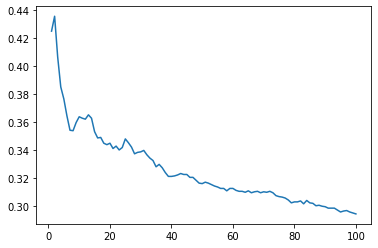

In [16]:
plt.plot(range(1,101), accuracies, label = "accuracies") 